In [45]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,bmat
import gc

from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

import xgboost as xgb

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']

In [ ]:
data = pd.concat([pd.read_csv('./../new_data/%d.csv' % year)[['Cat','Shots_taken_from_location','Started_at_Z',
        'Distance_from_hole','Hole','Round','Course_#','Year','Green_to_work_with']] for year in range(2003,2017)])

In [2]:
data = data[data.Cat=='Green']

NameError: name 'data' is not defined

In [ ]:
test_inds = np.random.choice(range(len(data)),len(data)/5,replace=False)
test_set = set(test_inds.tolist())
train_inds = np.array([ind for ind in range(len(data)) if ind not in test_set])
train = data.iloc[train_inds,:]
test = data.iloc[test_inds,:]
data = None
gc.collect();

In [ ]:
len(train),len(test)

In [ ]:
train.insert(len(train.columns),'Year-Course',train.Year.astype(str).str.cat(train['Course_#'].astype(str),sep='-'))
test.insert(len(test.columns),'Year-Course',test.Year.astype(str).str.cat(test['Course_#'].astype(str),sep='-'))
train.insert(len(train.columns),'Hole-Course',train.Hole.astype(str).str.cat(train['Course_#'].astype(str),sep='-'))
test.insert(len(test.columns),'Hole-Course',test.Hole.astype(str).str.cat(test['Course_#'].astype(str),sep='-'))

train.insert(len(train.columns),'Hole-Year-Course',train.Hole.astype(str).str.cat(
                                    [train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Hole-Year-Course',test.Hole.astype(str).str.cat(
                                    [test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))
train.insert(len(train.columns),'Round-Year-Course',train.Round.astype(str).str.cat(
                                    [train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Round-Year-Course',test.Round.astype(str).str.cat(
                                    [test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))

train.insert(len(train.columns),'Hole-Round-Year-Course',train.Hole.astype(str).str.cat(
                        [train.Round.astype(str),train.Year.astype(str),train['Course_#'].astype(str)],sep='-'))
test.insert(len(test.columns),'Hole-Round-Year-Course',test.Hole.astype(str).str.cat(
                        [test.Round.astype(str),test.Year.astype(str),test['Course_#'].astype(str)],sep='-'))

In [ ]:
test.head(3)

In [ ]:
lbins = {}

In [ ]:
X_train = csr_matrix(train.values[:,np.array([2,3])].astype(float))
for col in [6,9,10,11,12,13]:
    lbins[col] = LabelBinarizer(sparse_output=True)
    lbins[col].fit(train.values[:,col].astype(str))
    X_train = bmat([[X_train,lbins[col].transform(train.values[:,col].astype(str))]],format='csr')

In [ ]:
y_train = train.Shots_taken_from_location.values

In [ ]:
train = None
gc.collect();

In [ ]:
X_test = csr_matrix(test.values[:,np.array([2,3])].astype(float))
for col in [6,9,10,11,12,13]:
    X_test = bmat([[X_test,lbins[col].transform(test.values[:,col].astype(str))]],format='csr')

In [ ]:
y_test = test.Shots_taken_from_location.values

In [ ]:
test = None
gc.collect();

In [ ]:
assert X_train.shape[1]==X_test.shape[1]

In [ ]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [ ]:
X_train,X_test,y_train,y_test = None,None,None,None
gc.collect();

In [ ]:
params = {'objective':'reg:linear','silent':0,'eta':.03,'max_depth':6,'subsample':.5,'min_child_weight':5,
          'alpha':.3,'lambda':1.5}
watchlist  = [(dtrain,'train'),(dtest,'eval')]
num_round = 100000

In [ ]:
bst = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=25)

In [ ]:
bst.best_iteration

In [ ]:
data = pd.concat([pd.read_csv('./../new_data/%d.csv' % year)[['Cat','Shots_taken_from_location','Started_at_Z',
        'Distance_from_hole','Hole','Round','Course_#','Year','Green_to_work_with','Player_#']] for year in range(2003,2017)])
data = data[data.Cat=='Green']

data.insert(len(data.columns),'Year-Course',data.Year.astype(str).str.cat(data['Course_#'].astype(str),sep='-'))
data.insert(len(data.columns),'Hole-Course',data.Hole.astype(str).str.cat(data['Course_#'].astype(str),sep='-'))

data.insert(len(data.columns),'Hole-Year-Course',data.Hole.astype(str).str.cat(
                                    [data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))
data.insert(len(data.columns),'Round-Year-Course',data.Round.astype(str).str.cat(
                                    [data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))

#data.insert(len(data.columns),'Hole-Round-Year-Course',data.Hole.astype(str).str.cat(
                        #[data.Round.astype(str),data.Year.astype(str),data['Course_#'].astype(str)],sep='-'))

lbins = {}
X = csr_matrix(data.values[:,np.array([2,3])].astype(float))
for col in [6,9,10,11,12]:
    lbins[col] = LabelBinarizer(sparse_output=True)
    X = bmat([[X,lbins[col].fit_transform(data.values[:,col].astype(str))]],format='csr')

y = data.Shots_taken_from_location.values

groups = ['-'.join(map(str,tup)) for tup in data[['Hole','Round','Course_#','Year','Player_#']].values.tolist()]
le = LabelEncoder()
groups = le.fit_transform(groups)

'Green' = 1724

In [8]:
feature_names = ['elev_change','distance'] + ['Course = ' + name for name in lbins[6].classes_] + \
                ['Year = ' + name.strip().split('-')[0] + ', Course = ' + name.strip().split('-')[1] for name in lbins[9].classes_] + \
                ['Hole = ' + name.split('-')[0] + ', Course = ' + name.split('-')[1] for name in lbins[10].classes_] + \
                ['Hole = ' + name.split('-')[0] + ', Year = ' + name.split('-')[1] + ', Course = ' + name.split('-')[2] for name in lbins[11].classes_] + \
                ['Round = ' + name.split('-')[0] + ', Year = ' + name.split('-')[1] + ', Course = ' + name.split('-')[2] for name in lbins[12].classes_] + \
                ['Hole = ' + name.split('-')[0] + ', Round = ' + name.split('-')[1] + ', Year = ' + name.split('-')[2] + ', Course = ' + name.split('-')[3] for name in lbins[13].classes_]

In [9]:
d = {(feature_names[int(key[1:])],int(key[1:])):value for key,value in bst.get_score().iteritems()}
df = pd.DataFrame({'label': [key[0] for key in d.iterkeys()],'ind': [key[1] for key in d.iterkeys()]
                   ,'count': [d[key] for key in d.iterkeys()]})
d = {feature_names[int(key[1:])]:(int(key[1:]),value) for key,value in bst.get_score().iteritems()}

NameError: name 'bst' is not defined

In [10]:
dMat = xgb.DMatrix(X,label=y)

In [60]:
def get_best_estimators(params,X,y,groups,useTrainCV=True,cv_folds=5,early_stopping_rounds=50):
    cv = GroupShuffleSplit(n_splits=5, test_size=0.2)
    errors,best_its = [],[]
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test],label=y[test])
        watchlist  = [(dtrain,'train'),(dtest,'eval')]
        num_round = 100000
        bst = xgb.train(params,dtrain,num_round,watchlist,early_stopping_rounds=early_stopping_rounds)        
        best_its.append(bst.best_iteration)
        errors.append(np.mean((bst.predict(dtest,ntree_limit=bst.best_iteration) - y[test])**2))
    print errors
    print np.array(errors).mean(),np.array(errors).std()
    print best_its
    print np.array(best_its).mean(),np.array(best_its).std()

In [61]:
params = {'objective':'reg:linear','silent':0,'eta':.3,'max_depth':5,'subsample':.7,'min_child_weight':10,'alpha':.2,
          'lambda':1.5}

In [62]:
get_best_estimators(params,X,y,groups)

[0]	train-rmse:0.776474	eval-rmse:0.7767
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.595401	eval-rmse:0.59557
[2]	train-rmse:0.482345	eval-rmse:0.48246
[3]	train-rmse:0.415895	eval-rmse:0.415975
[4]	train-rmse:0.379092	eval-rmse:0.379143
[5]	train-rmse:0.359653	eval-rmse:0.359692
[6]	train-rmse:0.349714	eval-rmse:0.349744
[7]	train-rmse:0.344739	eval-rmse:0.344767
[8]	train-rmse:0.342268	eval-rmse:0.342296
[9]	train-rmse:0.341033	eval-rmse:0.341068
[10]	train-rmse:0.340414	eval-rmse:0.340449
[11]	train-rmse:0.340098	eval-rmse:0.340139
[12]	train-rmse:0.339935	eval-rmse:0.33998
[13]	train-rmse:0.339847	eval-rmse:0.339896
[14]	train-rmse:0.339793	eval-rmse:0.339851
[15]	train-rmse:0.339759	eval-rmse:0.339822
[16]	train-rmse:0.339739	eval-rmse:0.339804
[17]	train-rmse:0.339723	eval-rmse:0.33979
[18]	train-rmse:0.339711	eval-rmse:0.339783
[19]	train-rmse:0.339696	eval-rmse:0.

In [251]:
len(bst.get_score())

7174

In [252]:
len(feature_names)

52674

In [223]:
df.sort_values('count',ascending=False).head(10).reset_index(drop=True)

,count,ind,label
0,24774,1,distance
1,16243,0,elev_change
2,234,18,Course = 5
3,200,19,Course = 500
4,180,53,Course = 698
5,99,35131,"Hole = 18, Round = 4, Year = 2004, Course = 512"
6,85,11,Course = 27
7,80,16,Course = 4
8,66,84,Course = 8
9,58,8,Course = 21


In [224]:
arr = np.zeros(52674)
arr[0] = -1
arr[1] = 10
arr = xgb.DMatrix(csr_matrix(arr),feature_names = dMat.feature_names)
bst.predict(arr)

array([ 1.60038781], dtype=float32)

In [256]:
try: print d['Hole = 18, Round = 4, Year = 2004, Course = 512']
except: print 'none'
try: print d['Round = 4, Year = 2004, Course = 512']
except: print 'none'
try: print d['Hole = 18, Course = 512']
except: print 'none'
try: print d['Year = 2004, Course = 512']
except: print 'none'
try: print d['Course = 512']
except: print 'none'

(35131, 99)
(13667, 2)
(1423, 4)
none
(24, 4)


In [261]:
preds1 = []
preds2 = []
for dist in np.linspace(0.01,100,350):
    arr = np.zeros(52674)
    arr[1] = dist
    arr[0] = 0
    preds1.append(bst.predict(xgb.DMatrix(csr_matrix(arr),feature_names = dMat.feature_names)).tolist()[0])
    arr[35131] = 1
    arr[13667] = 1
    arr[1423] = 1
    arr[24] = 1
    preds2.append(bst.predict(xgb.DMatrix(csr_matrix(arr),feature_names = dMat.feature_names)).tolist()[0])

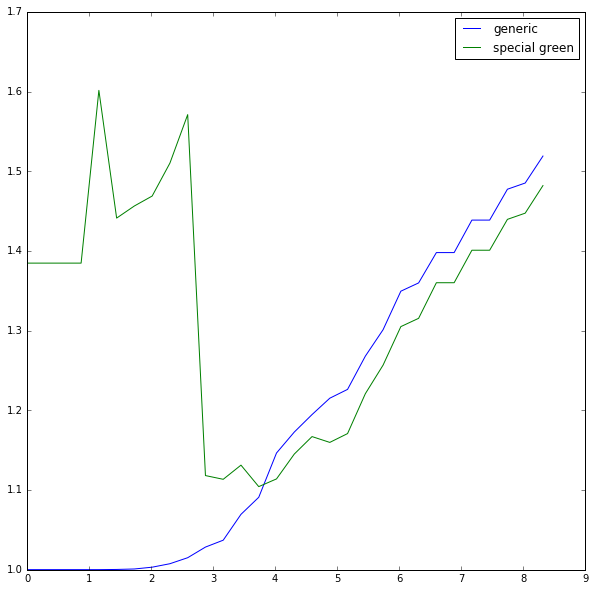

In [264]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.01,100,350)[0:30],preds1[0:30],label='generic');
plt.plot(np.linspace(0.01,100,350)[0:30],preds2[0:30],label='special green');
plt.legend();

In [140]:
np.array(preds1)-np.array(preds2)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [128]:
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
gbr = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=.6, 
                                criterion='friedman_mse', min_samples_split=20, min_samples_leaf=5, 
                                max_depth=3, verbose=5)

In [59]:
arr = np.zeros(52674)
arr[0] = 0
arr[1] = 1
gbr.predict(np.matrix(arr))

array([ 1.00236724])

In [13]:
(gbr.feature_importances_!=0).sum()

110

In [18]:
for ind in np.argsort(gbr.feature_importances_)[::-1][:25]:
    print ind,dMat.feature_names[ind],gbr.feature_importances_[ind]

1 distance 0.556955686945
0 elev_change 0.129763714639
18 5 0.0229025042378
19 500 0.0219273866748
53 698 0.0168980515402
11 27 0.0155810514021
37 638 0.0115623483092
8 21 0.0107309897729
16 4 0.0101223533737
84 8 0.00882717727138
511 2013-698 0.00836768322301
13569 R3-2016-11 0.00687930821898
44 669 0.00650830815584
22 510 0.00644785482103
42 660 0.00599763445695
55 700 0.00587940611933
14252 1-1-2005-6 0.00579147571969
76 770 0.0050384112391
98 2003-4 0.00491727288873
33497 18-1-2003-649 0.00439810752105
41 656 0.00410270631471
399 2010-698 0.00405507201267
1843 6-500 0.00396162690958
29770 16-2-2004-13 0.00384030511142
197 2005-638 0.00383654106862


In [5]:
gbr.fit(X,y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2508           0.0313           18.73m
         2           0.2255           0.0254           17.95m
         3           0.2048           0.0206           17.59m
         4           0.1879           0.0168           17.30m
         5           0.1744           0.0136           17.06m
         6           0.1636           0.0110           16.85m
         7           0.1545           0.0090           16.64m
         8           0.1472           0.0073           16.44m
         9           0.1413           0.0059           16.24m
        10           0.1365           0.0048           16.05m
        11           0.1325           0.0039           15.85m
        12           0.1293           0.0032           15.66m
        13           0.1270           0.0026           15.49m
        14           0.1247           0.0021           15.31m
        15           0.1232           0.0017           15.12m
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=5, min_samples_split=20,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.6, verbose=5,
             warm_start=False)

In [32]:
preds1 = []
preds2 = []
for dist in np.linspace(0,100,100):
    arr = np.zeros(52674)
    arr[1] = dist
    arr[0] = -.1
    preds1.append(gbr.predict(np.matrix(arr)))
    arr[0] = .1
    preds2.append(gbr.predict(np.matrix(arr)))

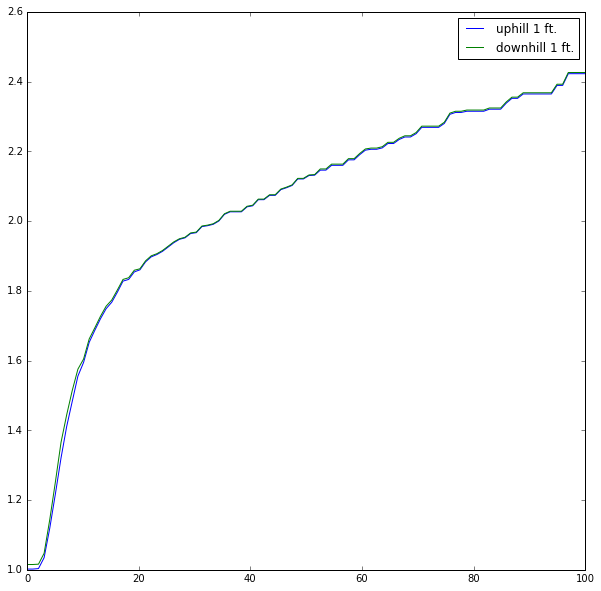

In [33]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0,100,100),preds1,label='uphill 1 ft.');
plt.plot(np.linspace(0,100,100),preds2,label='downhill 1 ft.');
plt.legend();

In [ ]:
for arg,num in zip(np.argsort(gbr.feature_importances_)[::-1],np.sort(gbr.feature_importances_)[::-1])[0:7]:
    print arg,num

In [ ]:
fig,axs = plot_partial_dependence(gbr,X_train_m2,[4],feature_names=,n_jobs=1,grid_resolution=50)

In [ ]:
np.mean(((lcv.predict(normalizer.transform(X_test)) + gbr.predict(X_test_m))/2 - y_test)**2)

In [ ]:
(((data.Cat=="Green").sum()*0.11545806607753986 +
 (data.Cat=="Fairway").sum()*0.31740937289 +
 (data.Cat=="Intermediate Rough").sum()*0.300202209856 +
 (data.Cat=="Primary Rough").sum()*0.361347962243 +
 (data.Cat=="Fringe").sum()*0.182508595153 + 
 (data.Cat=="Bunker").sum()*0.372257282426 +
 (data.Cat=="Other").sum()*0.493646743899)/len(data))**.5